# Calculating the COVID-19 mobility change impact on UK National Rail TfL Tube in London

## Project: Prediction of UK National Rail London TfL Tube Demand based on COVID-19 Community Data
In the times of global lockdown, public transportation became one of the most affected industries. Transport for London (TfL)'s fares income, for example, has fallen by 90% during lockdown. At the end of May, TfL has secured a £1.6bn (US$2bn) bailout from the government.

A partial service has been operating only since the UK first went into lockdown on 23 March 2020. No service cuts were made prior to that down, even though the number of passengers has been crashing significantly since the beginning of March.

In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.set_option('display.max_colwidth', 500)
%matplotlib inline

## Preparing and getting familiar the data
-------------------------------------------

The first dataset used is Google COVID-19 Community Mobility Reports: https://www.google.com/covid19/mobility/

While the data is categorized by region, I'll use only the Greater London subregion of the UK to compare it to the changes in National Rail TfL Tube use in the UK. (Greater London is where the TfL Tube operates)
The data shows how visitors to (or time spent in) categorized places change compared to the baseline days. A baseline day represents a normal value for that day of the week (so it represents 7 values for each day). The baseline day is the median value from the 5‑week period Jan 3 – Feb 6, 2020. 

The second dataset used reflects Transport use during the COVID-19 pandemic in the UK: https://www.gov.uk/government/statistics/transport-use-during-the-coronavirus-covid-19-pandemic

The full time series for these statistics is published starting 16 March 2020. To get a fuller picture, we combined it with the previous dataset on Transport use during the COVID-19 pandemic in the UK, available here:
https://www.gov.uk/government/publications/slides-to-accompany-coronavirus-press-conference-30-march-2020

While the two datasets are categorized by means of transport, I'll use only the National Rail and TfL Tube data. TfL tube reductions were compared to the equivalent day last year. Usage is measured by entry/exit data from tube stations and bus boarding taps. This is then compared to equivalent data from 1 year ago and to other trends to gauge the extent to which travel has been reduced.

*Note: Although the baseline for National Rail and TfL Tube use in the UK is set in the different time period, its choice is also justifiable. According to the source, the use of the Tube varies by ~20% seasonally and can seriously affect the results.*

In [2]:
# importing data from the csv-files
path_mobility_report = 'data/Global_Mobility_Report.csv'
path_transport_mar_may = 'data/Transport_Use_mar_may.csv'
path_transport_feb_mar = 'data/Transport_Use_feb_mar.csv'

df_mobility = pd.read_csv(path_mobility_report, parse_dates = ['date'], dayfirst=False, low_memory=False) # Google mobility reports
df_transport_feb_mar = pd.read_csv(path_transport_feb_mar, parse_dates = ['Date']) # the first UK transport dataset
df_transport_mar_may = pd.read_csv(path_transport_mar_may, parse_dates = ['Date'], dayfirst=True) # the second UK transport dataset

In [3]:
# cleaning the data for UK transport in February-March
df_transport_feb_mar = df_transport_feb_mar.transpose()
df_transport_feb_mar.reset_index(level=0, inplace=True)
df_transport_feb_mar.columns = ['Date', 'All motor vehicles','National rail', 'TfL - Tube % change', 'TfL - Bus % change']
df_transport_feb_mar.drop(df_transport_feb_mar.index[0], inplace=True)
date_df = pd.DataFrame({'year': [2020]*34,
                   'month': [2]*4+[3]*30,
                   'day': [1,27,28,29]+list(range(1,31))})
df_transport_feb_mar['Date'] = pd.to_datetime(date_df)
df_transport_mar_may.dropna(inplace = True)

# turn percentage into integers
def into_int(column):
    '''
    param column: a column in a dataframe / a list with percentages
    '''
    list1 = []
    for i in column:
        l = int(i[:-1])-100
        list1.append(l)
    return list1
df_transport_mar_may['Percentage'] = into_int(df_transport_mar_may['Percentage'])
df_transport_mar_may.head()

,Date,Transport Type,Percentage
0,2020-03-16,Car,-4
1,2020-03-17,Car,-13
2,2020-03-18,Car,-20
3,2020-03-19,Car,-21
4,2020-03-20,Car,-22


In [4]:
# combine the data in both UK-transport reports for the needed transport type
def add_transport(column_name, sec_column_name):
    '''
    param column_name: name of the column in the first part of the UK-transport report
    param sec_column_name: name of the column in the second part of the UK-transport report
    '''
    type_transport = df_transport_mar_may[df_transport_mar_may['Transport Type'] == column_name]
    transport_add = df_transport_feb_mar[df_transport_feb_mar["Date"].isin(pd.date_range("2020-02-27", "2020-03-15"))][['Date',sec_column_name]]
    transport_add.columns = ['Date', 'Percentage']
    transport_add['Percentage'] = into_int(transport_add['Percentage'])

    transport_added = pd.concat([transport_add,type_transport], sort=True)
    del transport_added['Transport Type']
    return transport_added
    
# combine the reports for TfL Tube
tfl_tube = add_transport('TfL Tube', 'TfL - Tube % change')
tfl_tube.rename(columns={'Percentage': 'Tfl Tube use change percentage'}, inplace=True)

# combine the reports for National Rail
national_rail = add_transport('National Rail', 'National rail')
national_rail.rename(columns={'Percentage': 'National rail use change percentage'}, inplace=True)

# combine the reports for TfL Bus
tfl_bus = add_transport('TfL Bus', 'TfL - Bus % change')
tfl_bus.rename(columns={'Percentage': 'Tfl Bus use change percentage'}, inplace=True)
tfl_bus.head() # as we can see, the data for tfl bus is not fully represented for the given dates under analysis, so I decided not to include it

,Date,Tfl Bus use change percentage
1,2020-02-27,-4
2,2020-02-28,-5
3,2020-02-29,-8
4,2020-03-01,2
5,2020-03-02,-3


In [5]:
# Choose the UK as the region under analysis for mobility
uk_mobility = df_mobility[df_mobility['country_region'] == 'United Kingdom']
uk_mobility['sub_region_1'].replace({np.nan: ' '}, inplace = True)

# choose the columns and dates required for the analysis
uk_mobility = uk_mobility[uk_mobility['date'].isin(pd.date_range('2020-02-27', '2020-05-29'))]
uk_mobility.rename(columns={'date':'Date'}, inplace=True)
# choose Greater London as the sub-region under analysis
london_mobility = uk_mobility[uk_mobility['sub_region_1'] == 'Greater London']
all_uk_mobility = uk_mobility[uk_mobility['sub_region_1'] == ' ']
# drop the sub-region column after the region is chosen
london_mobility = london_mobility.iloc[:,4:]
# check for missing values
london_mobility.isnull().any()
london_mobility.head()

,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
56083,2020-02-27,0.0,-1.0,4.0,-1.0,0.0,1.0
56084,2020-02-28,-2.0,-1.0,-9.0,-2.0,0.0,1.0
56085,2020-02-29,-2.0,0.0,-21.0,-5.0,0.0,1.0
56086,2020-03-01,9.0,4.0,24.0,5.0,1.0,-1.0
56087,2020-03-02,2.0,6.0,15.0,-3.0,1.0,0.0


## Merge the Data

To make the further analysis easier, combine the data into a single DataFrame that allows to analyze the different features with respect to each other. It can be done by merging the two DataFrames together, joining them on the `Date` column they have in common.

In [6]:
df_london_merged = pd.merge(london_mobility, tfl_tube, how='left', on='Date')
df_london_merged = pd.merge(df_london_merged, national_rail, how='left', on='Date')
# check for missing values
df_london_merged.isna().any()
df_london_merged.head()

,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Tfl Tube use change percentage,National rail use change percentage
0,2020-02-27,0.0,-1.0,4.0,-1.0,0.0,1.0,-1,-3
1,2020-02-28,-2.0,-1.0,-9.0,-2.0,0.0,1.0,-3,-7
2,2020-02-29,-2.0,0.0,-21.0,-5.0,0.0,1.0,-7,-7
3,2020-03-01,9.0,4.0,24.0,5.0,1.0,-1.0,4,-7
4,2020-03-02,2.0,6.0,15.0,-3.0,1.0,0.0,-5,-9


In [7]:
df_uk_merged = pd.merge(all_uk_mobility, tfl_tube, how='left', on='Date')
df_uk_merged = pd.merge(df_uk_merged, national_rail, how='left', on='Date')
# check for missing values
df_uk_merged.isna().any()
df_uk_merged.head()

,country_region_code,country_region,sub_region_1,sub_region_2,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Tfl Tube use change percentage,National rail use change percentage
0,GB,United Kingdom,,NaN,2020-02-27,2.0,1.0,8.0,0.0,0.0,0.0,-1,-3
1,GB,United Kingdom,,NaN,2020-02-28,1.0,1.0,-13.0,0.0,-1.0,1.0,-3,-7
2,GB,United Kingdom,,NaN,2020-02-29,1.0,1.0,-14.0,-2.0,0.0,0.0,-7,-7
3,GB,United Kingdom,,NaN,2020-03-01,7.0,2.0,14.0,5.0,1.0,-1.0,4,-7
4,GB,United Kingdom,,NaN,2020-03-02,4.0,4.0,14.0,0.0,1.0,0.0,-5,-9


## Exploratory Analysis
Now that all of the data are together, look at their relationship

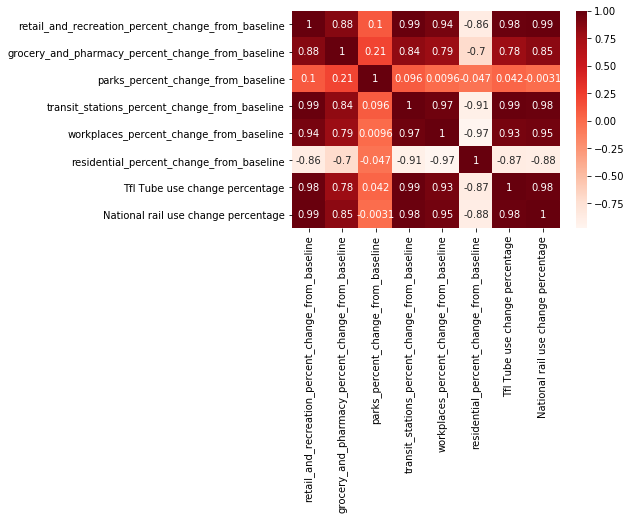

In [8]:
# look at the correlation coefficients with London mobility
transport_corr_london = df_london_merged.corr()
sns.heatmap(transport_corr_london, annot=True, cmap=plt.cm.Reds)
plt.show()

## Do the same analysis of the mobility variables for the whole United Kingdom data

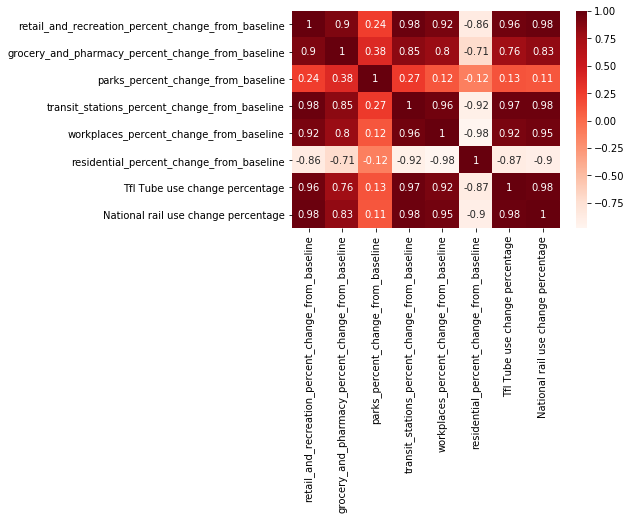

In [9]:
# look at the correlation coefficients with UK mobility
transport_corr_uk = df_uk_merged.corr()
sns.heatmap(transport_corr_uk, annot=True, cmap=plt.cm.Reds)
plt.show()

We can see that on crucial variables for both National Rail and TfL Tube, the correlation of London mobility is stronger than that with UK mobility.
So we can keep working with London mobility.

In [10]:
#Correlation with TfL Tube
cor_tube_london = abs(transport_corr_london["Tfl Tube use change percentage"])
cor_tube_london

retail_and_recreation_percent_change_from_baseline    0.983282
grocery_and_pharmacy_percent_change_from_baseline     0.782043
parks_percent_change_from_baseline                    0.042026
transit_stations_percent_change_from_baseline         0.988100
workplaces_percent_change_from_baseline               0.933984
residential_percent_change_from_baseline              0.865577
Tfl Tube use change percentage                        1.000000
National rail use change percentage                   0.977191
Name: Tfl Tube use change percentage, dtype: float64

## Choose the most significant Mobility Variables using Feature selection
Exclude the variables that are less relevant to transport use prediction
as the correlation scores show

In [11]:
#Selecting highly correlated features for TfL Tube
relevant_features_tube_london = cor_tube_london[cor_tube_london>0.9]
relevant_features_tube_london

retail_and_recreation_percent_change_from_baseline    0.983282
transit_stations_percent_change_from_baseline         0.988100
workplaces_percent_change_from_baseline               0.933984
Tfl Tube use change percentage                        1.000000
National rail use change percentage                   0.977191
Name: Tfl Tube use change percentage, dtype: float64

In [12]:
#Correlation of National Rail with London mobility
cor_rail_london = abs(transport_corr_london["National rail use change percentage"])
cor_rail_london

retail_and_recreation_percent_change_from_baseline    0.986000
grocery_and_pharmacy_percent_change_from_baseline     0.850943
parks_percent_change_from_baseline                    0.003087
transit_stations_percent_change_from_baseline         0.983194
workplaces_percent_change_from_baseline               0.950371
residential_percent_change_from_baseline              0.880612
Tfl Tube use change percentage                        0.977191
National rail use change percentage                   1.000000
Name: National rail use change percentage, dtype: float64

In [13]:
#Selecting highly correlated features for National Rail and London mobility
relevant_features_rail_london = cor_rail_london[cor_rail_london>0.9]
relevant_features_rail_london

retail_and_recreation_percent_change_from_baseline    0.986000
transit_stations_percent_change_from_baseline         0.983194
workplaces_percent_change_from_baseline               0.950371
Tfl Tube use change percentage                        0.977191
National rail use change percentage                   1.000000
Name: National rail use change percentage, dtype: float64

In [14]:
# Since irrelevant London mobility features are the same for both National Rail and TfL Tube, drop them
df_london_merged.drop(columns=['grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline'], inplace=True)
df_london_merged.head()

,Date,retail_and_recreation_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,Tfl Tube use change percentage,National rail use change percentage
0,2020-02-27,0.0,-1.0,0.0,-1,-3
1,2020-02-28,-2.0,-2.0,0.0,-3,-7
2,2020-02-29,-2.0,-5.0,0.0,-7,-7
3,2020-03-01,9.0,5.0,1.0,4,-7
4,2020-03-02,2.0,-3.0,1.0,-5,-9


<Figure size 936x576 with 0 Axes>

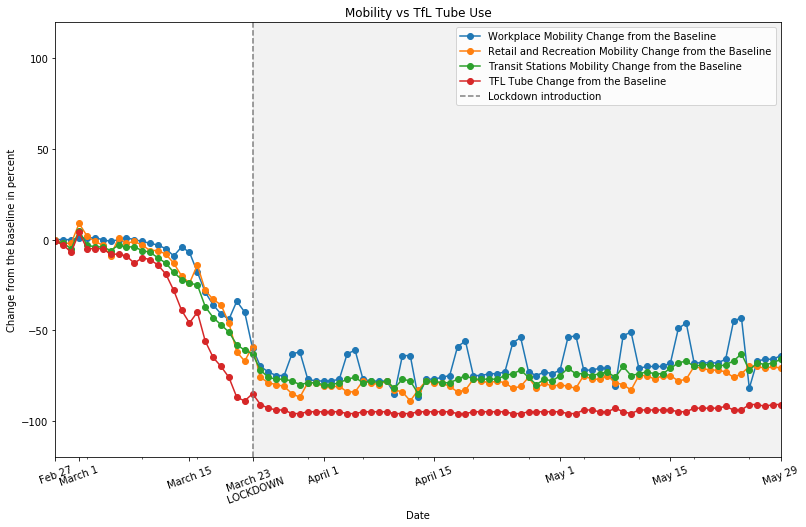

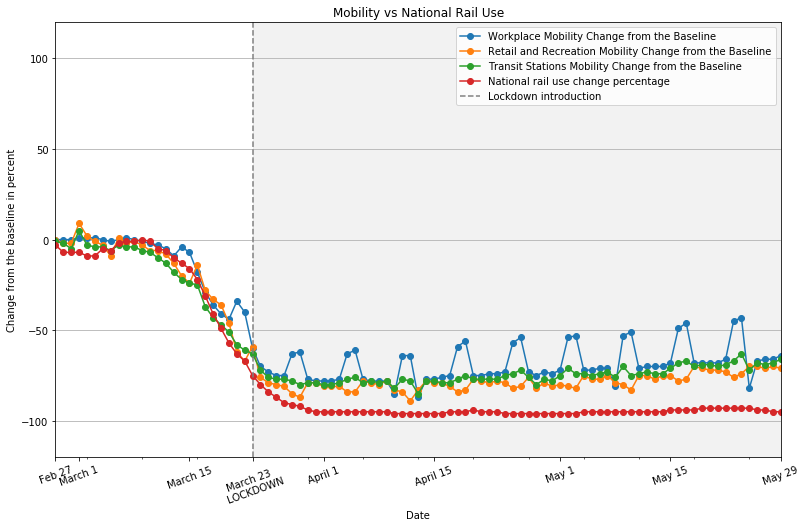

In [15]:
# plot the TfL Tube and National Rail with mobility features that have more than 90% correlation
plt.figure(figsize = (13, 8))
ax = df_london_merged.plot(figsize = (13, 8), x='Date', y='workplaces_percent_change_from_baseline', label = 'Workplace Mobility Change from the Baseline', marker = 'o')
df_london_merged.plot(x='Date', y='retail_and_recreation_percent_change_from_baseline', label = 'Retail and Recreation Mobility Change from the Baseline', ax=ax, marker = 'o')
df_london_merged.plot(x='Date', y='transit_stations_percent_change_from_baseline', label = 'Transit Stations Mobility Change from the Baseline', ax=ax, marker = 'o')
df_london_merged.plot(x='Date', y='Tfl Tube use change percentage', label = 'TFL Tube Change from the Baseline', ax=ax, marker = 'o')
ax.axvline(x='2020-03-23', color='gray', linestyle='--', label = 'Lockdown introduction')
ax.axvspan('2020-03-23', '2020-05-29', alpha=0.1, color='gray')
ax.set_ylabel('Change from the baseline in percent')
ax.set_xlabel('Date')
plt.xticks(['2020-02-27', '2020-03-01', '2020-03-15', '2020-03-23', '2020-04-01', '2020-04-15', '2020-05-01', '2020-05-15', '2020-05-29'], ['Feb 27', 'March 1', 'March 15', 'March 23 \n LOCKDOWN', 'April 1', 'April 15', 'May 1', 'May 15', 'May 29'],rotation=20)
plt.title("Mobility vs TfL Tube Use")
plt.ylim(-120, 120)

fig = df_london_merged.plot(figsize = (13, 8), x='Date', y='workplaces_percent_change_from_baseline', label = 'Workplace Mobility Change from the Baseline', marker = 'o')
df_london_merged.plot(x='Date', y='retail_and_recreation_percent_change_from_baseline', label = 'Retail and Recreation Mobility Change from the Baseline', ax=fig, marker = 'o')
df_london_merged.plot(x='Date', y='transit_stations_percent_change_from_baseline', label = 'Transit Stations Mobility Change from the Baseline', ax=fig, marker = 'o')
df_london_merged.plot(x='Date', y='National rail use change percentage', label = 'National rail use change percentage', ax=fig, marker = 'o')
fig.axvline(x='2020-03-23', color='gray', linestyle='--', label = 'Lockdown introduction')
fig.axvspan('2020-03-23', '2020-05-29', alpha=0.1, color='gray')
fig.set_ylabel('Change from the baseline in percent')
fig.set_xlabel('Date')
plt.title("Mobility vs National Rail Use")


plt.xticks(['2020-02-27', '2020-03-01', '2020-03-15', '2020-03-23', '2020-04-01', '2020-04-15', '2020-05-01', '2020-05-15', '2020-05-29'], ['Feb 27', 'March 1', 'March 15', 'March 23 \n LOCKDOWN', 'April 1', 'April 15', 'May 1', 'May 15', 'May 29'],rotation=20)
plt.ylim(-120, 120)
plt.grid(axis='y')
ax.legend()
fig.legend()
plt.show()


Both the correlation coefficient and graph shows that both National Rail and TfL use have a very strong correlation of change in workplace mobility, retail and recreation mobility, and transit stations mobility. One can conclude that the data are suitable for building a prediction model.

Transit stations include, besides subway stations, sea port, taxi stand, highway rest stop, and car rental agency, so they should not be considered to be equal to TfL use data.

The graphs also shows no huge spikes that could mark significant outliers in the data. Therefore, we cannot assume any signicant dataset errors.

## Investigating the Relationship of COVID-19 Transport and Mobility change and New COVID-19 Cases
The first dataset used reflects daily new cases of COVID-19 worldwide and is maintained by Our World in Data:
https://ourworldindata.org/coronavirus-source-data

The second dataset used reflects daily new cases of COVID-19 in different regions of the UK and is maintained by GOV.uk:
https://coronavirus.data.gov.uk/

In [16]:
# import the new cases data for London, world and the UK
path_new_cases = 'data/New_Cases.csv' # data for world and individual countries
path_new_cases_london = 'data/New_Cases_London.csv' # data for London

df_new_cases = pd.read_csv(path_new_cases, parse_dates = ['date'], dayfirst=True)
df_new_cases_london = pd.read_csv(path_new_cases_london, parse_dates = ['date'], dayfirst=True)
new_cases_london = df_new_cases_london[df_new_cases_london['Area name'] == 'London']
new_cases_london.head()

,Area name,Area code,Area type,date,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases,Cumulative lab-confirmed cases rate
3,London,E12000007,Region,2020-06-08,0.0,NaN,NaN,27194,NaN,NaN,305.3
479,London,E12000007,Region,2020-06-07,11.0,NaN,NaN,27194,NaN,NaN,305.3
593,London,E12000007,Region,2020-06-06,13.0,NaN,NaN,27183,NaN,NaN,305.1
773,London,E12000007,Region,2020-06-05,22.0,NaN,NaN,27170,NaN,NaN,305.0
1034,London,E12000007,Region,2020-06-04,18.0,NaN,NaN,27148,NaN,NaN,304.8


In [17]:
# clean the data for the UK and whole world
# choose the dates under analysis
new_cases_world_uk = df_new_cases[['date', 'United Kingdom', 'World']]
new_cases_world_uk.rename(columns={'date':'Date', 'United Kingdom': 'new_cases_uk', 'World': 'new_cases_world'}, inplace=True)
new_cases_world_uk = new_cases_world_uk[new_cases_world_uk['Date'].isin(pd.date_range('2020-02-27', '2020-05-29'))]
new_cases_world_uk.head()

,Date,new_cases_uk,new_cases_world
58,2020-02-27,0,1109
59,2020-02-28,3,1269
60,2020-02-29,2,1848
61,2020-03-01,5,1819
62,2020-03-02,13,2079


In [18]:
# prepare the data for london
# choose the region and the dates under analysis
new_cases_london = new_cases_london[['date','Cumulative lab-confirmed cases']]
new_cases_london.rename(columns={'date':'Date', 'Cumulative lab-confirmed cases': 'new_cases_london'}, inplace=True)
new_cases_london.sort_values(by='Date', inplace=True)

# by the total count of cases, calculate the daily number of cases in 10s (for easy plotting)
new_cases_l = [0]
for n in range(1, len(new_cases_london)):
    current = new_cases_london['new_cases_london'].tolist()[n]
    previous = new_cases_london['new_cases_london'].tolist()[n-1]
    new_cases_l.append((current-previous)/10)
new_cases_london['new_cases_london'] = new_cases_l
new_cases_london = new_cases_london[new_cases_london['Date'].isin(pd.date_range('2020-02-27', '2020-05-29'))]
new_cases_london.head()


,Date,new_cases_london
35807,2020-02-27,0.1
35778,2020-02-28,0.5
35767,2020-02-29,0.1
35709,2020-03-01,0.8
35649,2020-03-02,1.2


In [19]:
# for easier plotting, divide the number of new cases in UK by 100
new_cases_world_uk['new_cases_uk'] = new_cases_world_uk['new_cases_uk']/100
new_cases_world_uk['new_cases_world'] = new_cases_world_uk['new_cases_world']/1000


In [20]:
df_london_merged

,Date,retail_and_recreation_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,Tfl Tube use change percentage,National rail use change percentage
0,2020-02-27,0.0,-1.0,0.0,-1,-3
1,2020-02-28,-2.0,-2.0,0.0,-3,-7
2,2020-02-29,-2.0,-5.0,0.0,-7,-7
3,2020-03-01,9.0,5.0,1.0,4,-7
4,2020-03-02,2.0,-3.0,1.0,-5,-9
5,2020-03-03,-1.0,-4.0,1.0,-5,-9
6,2020-03-04,-3.0,-4.0,0.0,-5,-5
7,2020-03-05,-9.0,-6.0,-1.0,-8,-6
8,2020-03-06,1.0,-3.0,0.0,-8,-2
9,2020-03-07,-2.0,-4.0,1.0,-9,-1


In [21]:
# merge the UK mobility with new cases
df_cases_mobility = pd.merge(new_cases_london, new_cases_world_uk, how='left', on='Date')
df_cases_mobility = pd.merge(df_cases_mobility, df_london_merged, how='left', on='Date')

# check for missing values
df_cases_mobility.isna().any()

Date                                                  False
new_cases_london                                      False
new_cases_uk                                          False
new_cases_world                                       False
retail_and_recreation_percent_change_from_baseline    False
transit_stations_percent_change_from_baseline         False
workplaces_percent_change_from_baseline               False
Tfl Tube use change percentage                        False
National rail use change percentage                   False
dtype: bool

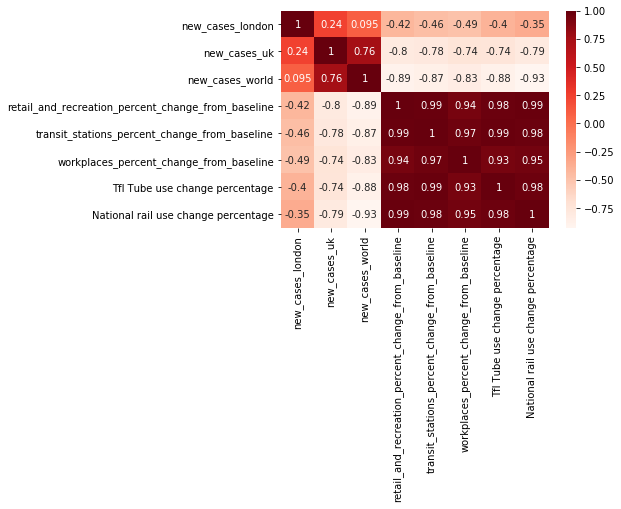

In [22]:
# look at the correlation of all variables
mobility_corr = df_cases_mobility.corr()
sns.heatmap(mobility_corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [23]:
#Correlation with New Cases in whole world
cor_world = abs(mobility_corr["new_cases_world"])
cor_world

new_cases_london                                      0.094919
new_cases_uk                                          0.758426
new_cases_world                                       1.000000
retail_and_recreation_percent_change_from_baseline    0.890155
transit_stations_percent_change_from_baseline         0.866504
workplaces_percent_change_from_baseline               0.828918
Tfl Tube use change percentage                        0.877642
National rail use change percentage                   0.927698
Name: new_cases_world, dtype: float64

In [24]:
#Correlation with New Cases in UK
cor_uk = abs(mobility_corr["new_cases_uk"])
cor_uk

new_cases_london                                      0.242351
new_cases_uk                                          1.000000
new_cases_world                                       0.758426
retail_and_recreation_percent_change_from_baseline    0.795168
transit_stations_percent_change_from_baseline         0.777202
workplaces_percent_change_from_baseline               0.735411
Tfl Tube use change percentage                        0.742857
National rail use change percentage                   0.794125
Name: new_cases_uk, dtype: float64

In [25]:
# look at the correlation with New Cases in London
cor_london = abs(mobility_corr["new_cases_london"])
cor_london

new_cases_london                                      1.000000
new_cases_uk                                          0.242351
new_cases_world                                       0.094919
retail_and_recreation_percent_change_from_baseline    0.417974
transit_stations_percent_change_from_baseline         0.463362
workplaces_percent_change_from_baseline               0.487131
Tfl Tube use change percentage                        0.398572
National rail use change percentage                   0.349810
Name: new_cases_london, dtype: float64

#### It can be observed that New daily cases in the whole world have much stronger correlation with both mobility and transport, so we can just drop other variables.

In [26]:
df_cases_mobility.drop(columns=['new_cases_london', 'new_cases_uk'], inplace=True)
df_cases_mobility.head()

,Date,new_cases_world,retail_and_recreation_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,Tfl Tube use change percentage,National rail use change percentage
0,2020-02-27,1.109,0.0,-1.0,0.0,-1,-3
1,2020-02-28,1.269,-2.0,-2.0,0.0,-3,-7
2,2020-02-29,1.848,-2.0,-5.0,0.0,-7,-7
3,2020-03-01,1.819,9.0,5.0,1.0,4,-7
4,2020-03-02,2.079,2.0,-3.0,1.0,-5,-9


<Figure size 936x576 with 0 Axes>

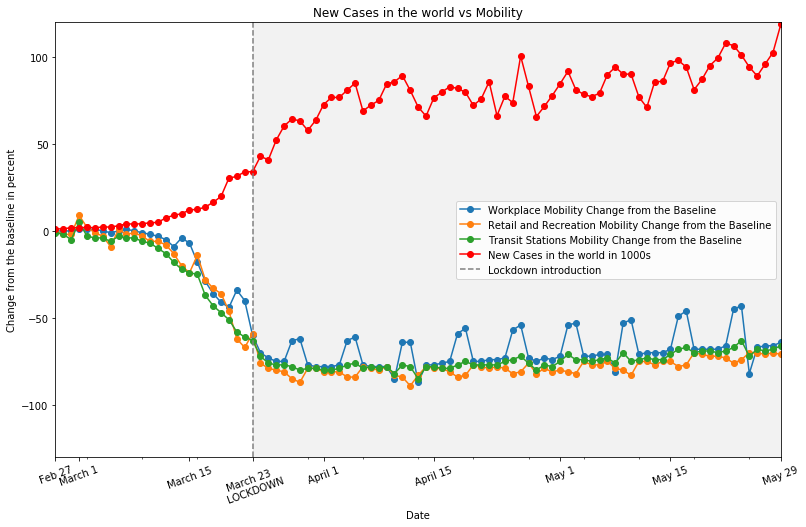

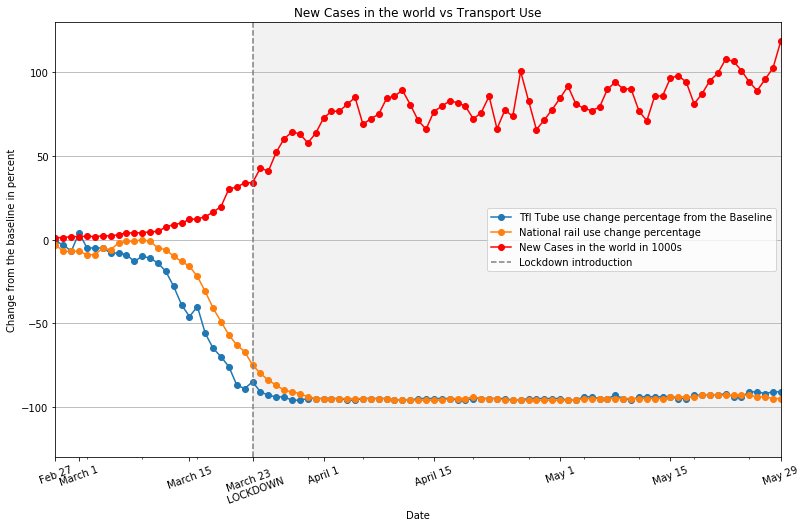

In [27]:
# plot new daily cases in the world on one graph
plt.figure(figsize = (13, 8))
ax = df_cases_mobility.plot(figsize = (13, 8), x='Date', y='workplaces_percent_change_from_baseline', label = 'Workplace Mobility Change from the Baseline', marker = 'o')
df_cases_mobility.plot(x='Date', y='retail_and_recreation_percent_change_from_baseline', label = 'Retail and Recreation Mobility Change from the Baseline', marker = 'o', ax=ax)
df_cases_mobility.plot(x='Date', y='transit_stations_percent_change_from_baseline', label = 'Transit Stations Mobility Change from the Baseline', marker = 'o', ax=ax)
df_cases_mobility.plot(x='Date', y='new_cases_world', label = 'New Cases in the world in 1000s', ax=ax, marker = 'o', color='red')
ax.axvline(x='2020-03-23', color='gray', linestyle='--', label = 'Lockdown introduction')
ax.axvspan('2020-03-23', '2020-05-29', alpha=0.1, color='gray')
plt.title("New Cases in the world vs Mobility")
plt.xticks(['2020-02-27', '2020-03-01', '2020-03-15', '2020-03-23', '2020-04-01', '2020-04-15', '2020-05-01', '2020-05-15', '2020-05-29'], ['Feb 27', 'March 1', 'March 15', 'March 23 \n LOCKDOWN', 'April 1', 'April 15', 'May 1', 'May 15', 'May 29'],rotation=20)
plt.ylim(-130, 120)
ax.set_ylabel('Change from the baseline in percent')
ax.set_xlabel('Date')

fig = df_cases_mobility.plot(figsize = (13, 8), x='Date', y='Tfl Tube use change percentage', label = 'Tfl Tube use change percentage from the Baseline', marker = 'o')
df_cases_mobility.plot(x='Date', y='National rail use change percentage', label = 'National rail use change percentage', ax=fig, marker = 'o')
df_cases_mobility.plot(x='Date', y='new_cases_world', label = 'New Cases in the world in 1000s', ax=fig, marker = 'o', color='red')
fig.axvline(x='2020-03-23', color='gray', linestyle='--', label = 'Lockdown introduction')
fig.set_ylabel('Change from the baseline in percent')
fig.set_xlabel('Date')
fig.axvspan('2020-03-23', '2020-05-29', alpha=0.1, color='gray')
plt.title("New Cases in the world vs Transport Use")
plt.ylim(-130, 130)
plt.xticks(['2020-02-27', '2020-03-01', '2020-03-15', '2020-03-23', '2020-04-01', '2020-04-15', '2020-05-01', '2020-05-15', '2020-05-29'], ['Feb 27', 'March 1', 'March 15', 'March 23 \n LOCKDOWN', 'April 1', 'April 15', 'May 1', 'May 15', 'May 29'],rotation=20)

plt.grid(axis='y')
ax.legend()
fig.legend()
plt.show()


Again, we can observe quite a strong correlation of New Daily Cases with many mobility variables.

The graph shows no huge spikes that mark significant outliers in the data. Therefore, we cannot assume any signicant dataset errors.

## Split the Data into Training and Testing Sets
Prior to modeling, I first break our data into a training set and a test set to be able to evaluate how well the future model performs. I use scikit-learn's `train_test_split` function to do this split


In [28]:
# create new DataFrames with columns I want to work on
grocery_mobility = df_cases_mobility['grocery_and_pharmacy_percent_change_from_baseline'].values
new_cases_uk = df_cases_mobility['new_cases_uk'].values
cases_train, cases_test, grocery_train, grocery_test = train_test_split(new_cases_uk, grocery_mobility, test_size = 0.2, random_state = 1)

KeyError: 'grocery_and_pharmacy_percent_change_from_baseline'

In [ ]:
grocery_train

In [ ]:
# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
X = cases_train.reshape(-1, 1)
y = grocery_train.reshape(-1, 1)

In [ ]:
from sklearn.svm import SVR

In [ ]:
svrModel = SVR(epsilon=0.16)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)
svrModel.fit(X,y)
# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X, y, color='red')
    sorted_x = sorted(X)
    plt.plot(sorted_x, pol_reg.predict(poly_reg.fit_transform(sorted_x)), color='blue')
    plt.plot(sorted_x, svrModel.predict(sorted_x), color="green")
    plt.title('Prediction of Workplace Mobility (Linear Regression)')
    plt.xlabel('Cases in the UK')
    plt.ylabel('Grocery Mobility')
    plt.show()
    return
viz_polymonial()

In [ ]:
svrModel.fit(X,y)

In [ ]:
y_pred = svrModel.predict(cases_test.reshape(-1,1))

In [ ]:
mse = mean_squared_error(grocery_test, y_pred)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse